# Examples of all the 4 types of moving clusters in the data

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import scipy.ndimage as img
import scipy.signal as signal 
import scipy.stats as stat
from scipy.signal import fftconvolve
from alphashape import alphashape
import matplotlib.patches as patch
from functools import partial
from astropy.stats import kuiper
from shapely.geometry import Polygon

In [2]:
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))
sys.path.append(parent_dir)
from Functions.Detection_functions import MCDA, circular_mask, preprocessing
from Functions.moving_cluster_class import Moving_Cluster

In [3]:
condition='awake' #between anesthesia and awake
session='spontaneous' #between evokedU, evokedD and spontaneous

In [4]:
original_data_directory=r'C:/Users/mmill/Documents/STAGE M1/DATA/'

In [5]:
if condition=='awake':
    if session=='evoked':
        bks_evoked_path = original_data_directory+'gaussian_pos4_ziggy_210908.npy'
        Data = np.load(bks_evoked_path)
    elif session=='spontaneous':
        bks_blank_path = original_data_directory+'blank_ziggy_210908.npy'
        Data = np.load(bks_blank_path)
    mean = np.nanmean(Data)
    nan_loc = np.isnan(Data)
    Data[nan_loc] = mean
    N_trials, Nt, Nx, Ny = Data.shape
    fs = 100 #Hz
    pixel_spacing = 0.045 #mm
    line=np.array([[ 47, 409],[ 87, 131]])
    circle =[[219, 187], 199]

if condition=='anesthesia':
    if session=='evokedD':
        anesth_evokedD_path = original_data_directory+'signal_240306_gaussianD.mat'
        file_anesth_evokedD = h5py.File(anesth_evokedD_path)['signal']
        Data = np.rot90(np.array(file_anesth_evokedD),2, axes=(2,3))
    elif session=='evokedU':
        anesth_evokedU_path = original_data_directory+'signal_240306_gaussianU.mat'
        file_anesth_evokedU = h5py.File(anesth_evokedU_path)['signal']
        Data = np.rot90(np.array(file_anesth_evokedU),2, axes=(2,3))
    elif session=='spontaneous':
        anesth_blank_path = original_data_directory+'signal_240306_blank.mat' #change it to adapt to your directories
        file_anesth_blank = h5py.File(anesth_blank_path)['signal']
        Data = np.rot90(np.array(file_anesth_blank), 2,axes=(2,3))
    N_trials, Nt, Nx, Ny = Data.shape
    fs=110 #Hz
    pixel_spacing = 0.064 #mm
    line=np.array([[251,   5],[ 90, 118]])
    circle=[[145, 125], 140]
mask = circular_mask((Nx,Ny), center=circle[0], radius=circle[1])

In [6]:
eps = 15 if condition=='anesthesia' else 20
MinPts=32
theta=.40 if condition == 'anesthesia' else .36

In [7]:
trial_number=7
test_trial=Data[trial_number]
preprocessed_trial = preprocessing(trial=test_trial, border_mask=mask, fs=fs, fc=30, threshold=99)

In [8]:
moving_clusters = MCDA(Trial=preprocessed_trial, Epsilon=eps, MinPts=MinPts, Theta=theta)
print(f'{len(moving_clusters)} MC detected')

2 MC detected


In [9]:
min_dist=1 #mm
sign_level=0.05 #5%

In [10]:
MC_list=[]
for index,mc in enumerate(moving_clusters):
    print(mc['trace'])
    MC=Moving_Cluster(mc['points'],mc['trace'], mc['alpha shapes'], fs, pixel_spacing, condition, session, trial_number, index)
    MC.classify(min_dist, sign_level)
    MC.propagation_direction(sign_level)
    print(MC.pattern_type)
    MC_list.append(MC)

[20, 21, 22, 23, 24]
Static
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Static


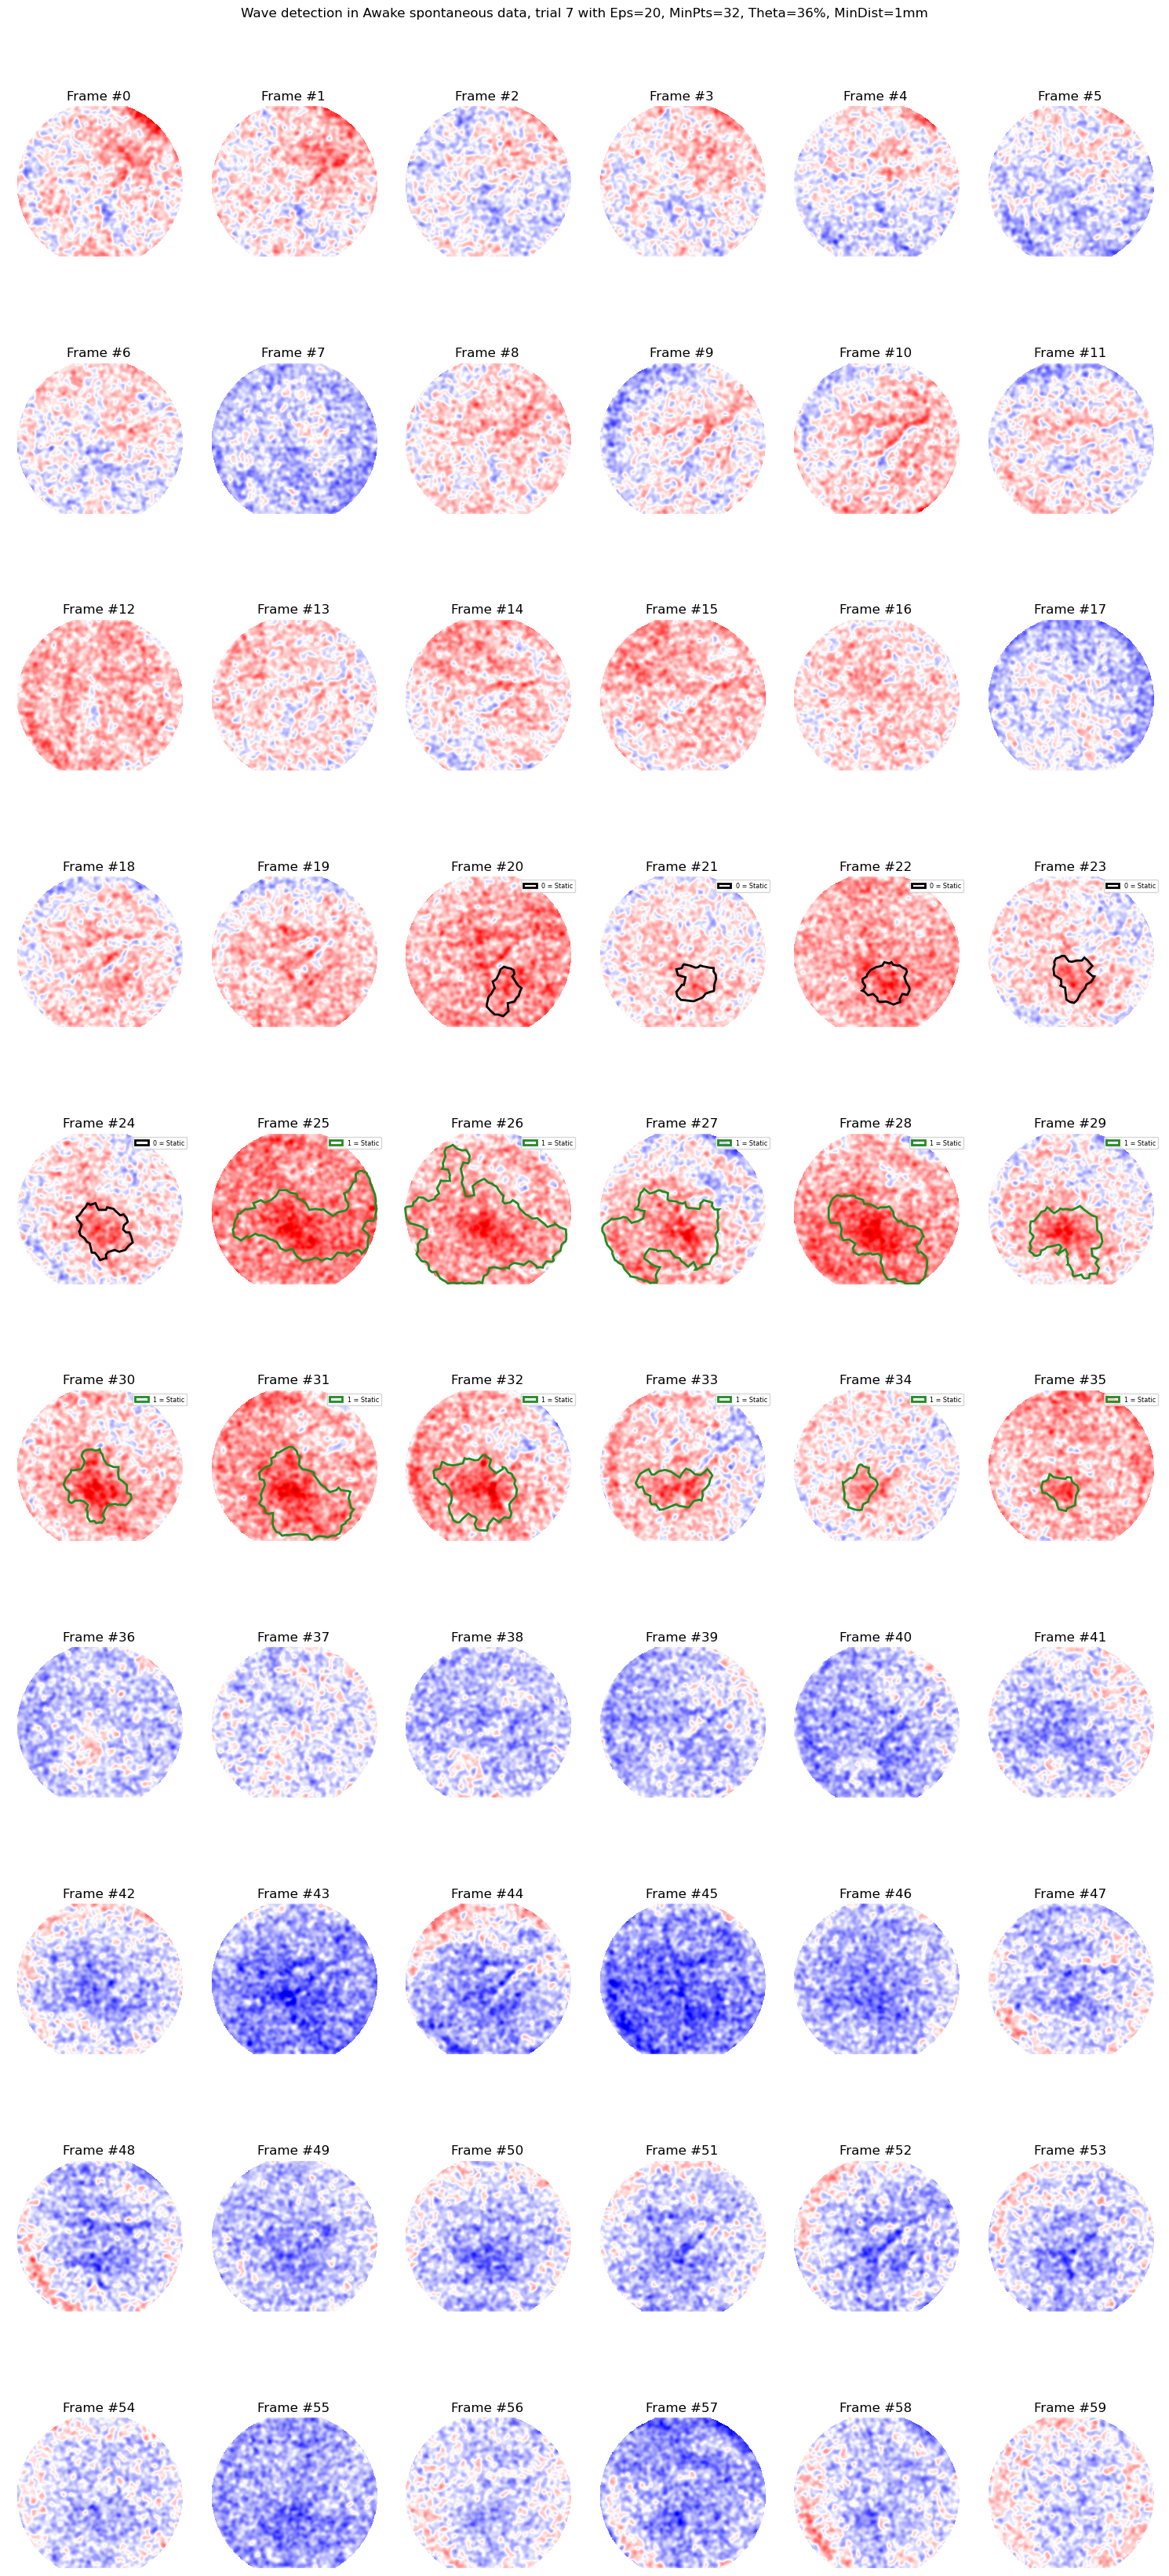

In [11]:
Norm = colors.Normalize(vmax=1, vmin=-1)
nlong=Nt//6
contour_colors=['black', 'forestgreen','dimgray','darkgreen','indigo','fuchsia', 'purple']
fig, axs = plt.subplots(nlong,6,layout='tight',figsize=(15,nlong*3.5))
fig.suptitle(f"Wave detection in {condition.capitalize()} {session} data, trial {trial_number} with Eps={eps}, MinPts={MinPts}, Theta={int(theta*100)}%, MinDist={min_dist}mm")

for k in range(Nt): #plot background
    bckgrnd=img.gaussian_filter(test_trial[k], sigma=4, mode='constant')
    bckgrnd[~mask]=None
    axs[k//6, k%6].imshow(bckgrnd, cmap='seismic', norm=Norm)
    #axs[k//6, k%6].imshow(img.gaussian_filter(test_trial[k], sigma=3, mode='constant')*mask, cmap='hsv', norm=Norm)
    axs[k//6, k%6].set_title(f'Frame #{k}')
    axs[k//6, k%6].axis('off')

for MC_numb,MC in enumerate(MC_list): 
    for i,j in enumerate(MC.trace):
        x,y = MC.shapes[i].exterior.xy
        position=np.vstack((y,x)).T
        mpl_poly = patch.Polygon(position, closed=True, edgecolor=contour_colors[MC_numb%len(contour_colors)], facecolor='none', linewidth=2, label=f'{MC_numb} = {MC.pattern_type}')
        axs[j//6, j%6].add_patch(mpl_poly)  #
        axs[j//6, j%6].legend(fontsize='xx-small')

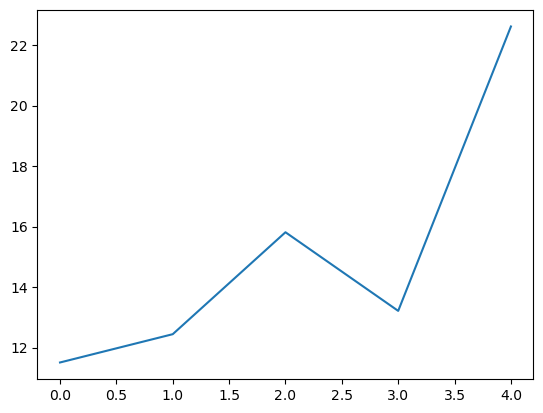

In [12]:
plt.figure()
plt.plot(MC_list[0].surfaces)

In [13]:
MC_list[0].test_radius

False

In [14]:
MC_list[0].test_surf

True

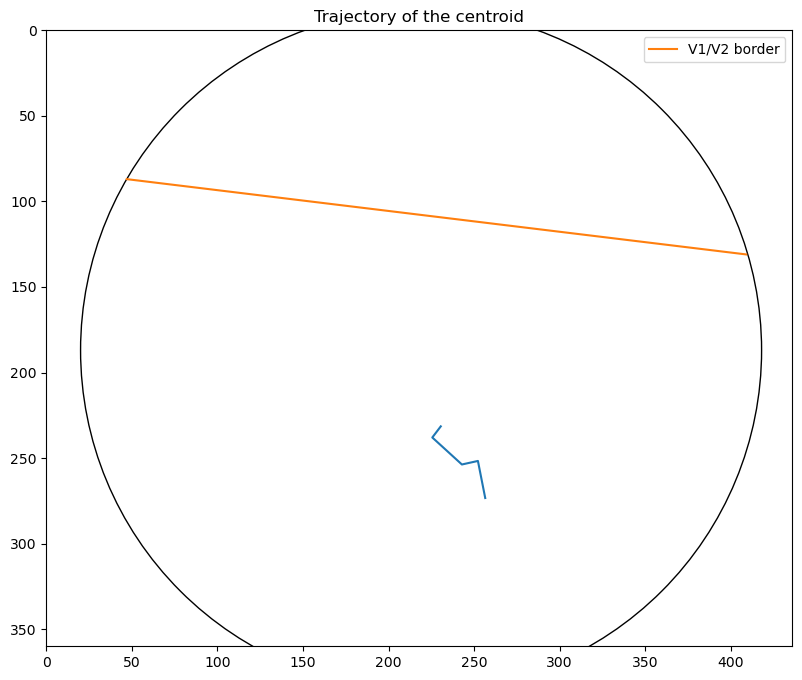

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('Trajectory of the centroid')
ax.plot(MC_list[0].centroids[:,1], MC_list[0].centroids[:,0])
ax.set_aspect('equal')
ax.add_patch(patch.Circle(circle[0], circle[1], color='k',fill=False))
ax.plot(line[0],line[1], label='V1/V2 border')
ax.set_xlim(0,Ny)
ax.set_ylim(0,Nx)
ax.invert_yaxis()
ax.legend()

In [16]:
MC_list[0].test_persistence

False

In [17]:
#fig.savefig('Nice mix of plane and radial waves')